<a href="https://colab.research.google.com/github/shahriarivari/Load-Forecasting-Machine-Learing/blob/main/load_forecasting_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# installing libraries

In [1]:
# installing jdatetime for converting date to Gregotian
# !pip install scikit-learn
# !pip install matplotlib
%pip install jdatetime
%pip install scikit-optimize
%pip install bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.2 MB/s eta 0:00:00


# Data manipulation

in this section a new data frame is created which has, time, power and temperature as its columns.
we have two seperate dataframes, one is the values for each hour of the day and the other one is the houlry temperature. These two dataframes will get concatinated into one.

## Importing Data

In [10]:
import pandas as pd # to import the excel file
import numpy as np
from data_manipulation import hourly_rows_data

## importing data files
data_df = pd.read_excel("consumption.xlsx") # includes each day in a row with hours of the day as columns
temperatue_df = pd.read_csv("temperature.csv") # includes the hourly temprature of eaach day

# convert our original dataframe to have each row represent an hour
hourly_data_frame = hourly_rows_data(df = data_df)

# adding another column to the new_df, which is the temperature of each hour using the temp_df
# changing the format to pd.datetime
temperatue_df["time"] = pd.to_datetime(temperatue_df['time'], format='%Y-%m-%dT%H:%M')

# now we concatinate the two data frames based on the 'time' column
concatinated_df = pd.concat([hourly_data_frame.set_index('time'), temperatue_df.set_index('time')], axis=1, join='inner')

# Reset the index to make 'time' a column again
concatinated_df.reset_index(inplace=True)
concatinated_df.head(2)


changed the data frame's shape from (730, 25) to (17520, 2)



,time,power,temp
0,2021-03-21 01:00:00,683.189471,6.7
1,2021-03-21 02:00:00,627.645948,6.1


### Plotting to get some information
plotting the "power" with respect to temperatue and time to see the relation between them


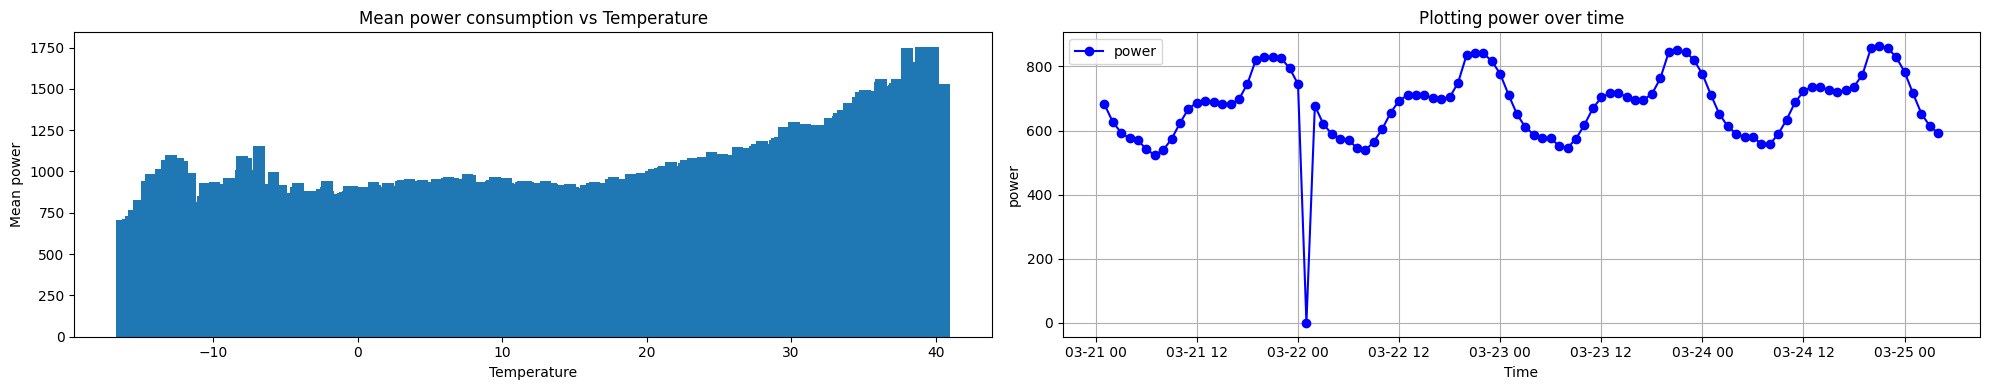

In [2]:
# plotting temperatue vs power consumption
import matplotlib.pyplot as plt
import numpy as np

unique_temps = np.unique(concatinated_df['temp'])

plt.figure(figsize=(20, 4))
# Plotting
plt.subplot(1, 2, 1)
plt.bar(unique_temps, concatinated_df.groupby('temp')['power'].mean())
plt.xlabel('Temperature')
plt.ylabel('Mean power')
plt.title('Mean power consumption vs Temperature')

plt.subplot(1, 2, 2)
# Plotting the power over the time column
plt.plot(concatinated_df['time'][:100], concatinated_df['power'][:100], label='power', marker='o', linestyle='-', color='b')
plt.title('Plotting power over time')
plt.xlabel('Time')
plt.ylabel('power')
plt.legend()
plt.grid(True)

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()

In [ ]:
# # convert columns to numeric values for correlation analysis
# numeric_df = historical_dataframe_extra_features.apply(pd.to_numeric, errors='coerce')

# columns_for_corr = numeric_df.columns

# # Calculate the correlation matrix
# correlation_matrix = numeric_df[columns_for_corr].corr()

# # filter the higly correlated features
# new_feature_columns = []
# for idx in correlation_matrix['target_power'].index:
#   if abs(correlation_matrix['target_power'][idx]) >= 0.2 :
#     new_feature_columns.append(idx)

# # extract a new datafarame form the main one with the columns that have higher corelation to the target_power
# highly_correlated_df = pd.DataFrame()
# for col in new_feature_columns:
#   highly_correlated_df[col] = historical_dataframe_extra_features[col]

# highly_correlated_df.head()

# Lightgbm Model
For our first model we are going to use Gradient Boosting Models using the "lightgbm" framework which uses tree based learning algorithms.


In [8]:
from sklearn.model_selection import KFold #Import the k-fold cross validation function in the machine learning library
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import lightgbm as lgb

## Data preparation
Now to train our GBM model, we need to prepare our dataset accordingly. Since we are going to predict a future value based on a window_size vaiable, first: we normalize the "power" column to have mean=0 and std =1, Then: we use the function "create_historical_dataset" to create a historical dataset based on the winodw_size varialbe.

In [60]:
from data_manipulation import std_normalizer ,create_historical_dataset

# Normalizing using the Standard Deviation Normalization method
normalized_concatinated_df , (normalized_mean , normalized_std) = std_normalizer(df= concatinated_df,col_name= "power")

# make a historical dataset for models to predict on.
window_size = 3
exclude_columns = ['time']  # Specify columns to exclude from lag feature creation
historical_dataframe = create_historical_dataset(normalized_concatinated_df, window_size, exclude_columns)


Normalization is done for column : power


In [19]:
# Drop any other columns that are not features or the target variable
features = historical_dataframe.drop(columns=['target_power','time'],axis =1).astype('float32')
target = historical_dataframe['target_power'].astype('float32')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

## Hyper-parameter tuning , using the BayesianOptimization
Here, before training the model, we use Bayesian Optimization technique to search for the best hyper-parameters, then we train the model with the best parameters obtained from this section.

In [18]:
# Define the objective function for Bayesian Optimization
def lgbm_cv(num_leaves, learning_rate, n_estimators, feature_fraction, bagging_fraction, bagging_freq, min_child_samples):
  params = {
    'objective': 'regression',
    'num_leaves': int(num_leaves),
    'learning_rate': learning_rate,
    'n_estimators': int(n_estimators),
    'feature_fraction': max(min(feature_fraction, 1), 0),
    'bagging_fraction': max(min(bagging_fraction, 1), 0),
    'bagging_freq': int(bagging_freq),
    'min_child_samples': int(min_child_samples),
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt'
    }

  # Perform K-Fold cross-validation on the training set
  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  rmse_scores = []

  for train_index, val_index in kf.split(X_train):
    X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_kf, y_train_kf)

    # Predict on the validation set and calculate RMSE
    y_pred = model.predict(X_val_kf)
    rmse = np.sqrt(mean_squared_error(y_val_kf, y_pred))
    rmse_scores.append(rmse)

  # Return the average RMSE across folds
  return -np.mean(rmse_scores)

# Define the parameter space for Bayesian Optimization
pbounds = {
  'num_leaves': (5, 50),
  'learning_rate': (0.01, 0.3),
  'n_estimators': (50, 200),
  'feature_fraction': (0.1, 0.9),
  'bagging_fraction': (0.1, 0.9),
  'bagging_freq': (1, 10),
  'min_child_samples': (5, 30)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
  f=lgbm_cv,
  pbounds=pbounds,
  random_state=42,
)

# Run Bayesian Optimization
optimizer.maximize(init_points=10, n_iter=30)

# Get the best hyperparameters
best_params = optimizer.max['params']
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['bagging_freq'] = int(best_params['bagging_freq'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])

|   iter    |  target   | baggin... | baggin... | featur... | learni... | min_ch... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.1711   | 0.3996    | 9.556     | 0.6856    | 0.1836    | 8.9       | 73.4      | 7.614     |
| 2         | -0.2076   | 0.7929    | 6.41      | 0.6665    | 0.01597   | 29.25     | 174.9     | 14.56     |
| 3         | -0.147    | 0.2455    | 2.651     | 0.3434    | 0.1622    | 15.8      | 93.68     | 32.53     |
| 4         | -0.1563   | 0.2116    | 3.629     | 0.3931    | 0.1423    | 24.63     | 79.95     | 28.14     |
| 5         | -0.1268   | 0.5739    | 1.418     | 0.586     | 0.05945   | 6.626     | 192.3     | 48.45     |
| 6         | -0.3585   | 0.7467    | 3.742     | 0.1781    | 0.2084    | 16.0      | 68.31     | 27.28     |
| 7         | -0.1721   | 0.1275    | 9.184     | 0.307     | 0.2021    | 12.79     | 128.0     | 29.6      |
| 8       

## Training the model
Train the model using the "best_params" from the previous part

In [20]:
# Train the final model with the best hyperparameters using the entire training set
best_params['metric'] = 'rmse'
best_params['verbosity'] = -1
best_params['boosting_type'] = 'gbdt'
best_params['objective'] = 'regression'

final_model = lgb.LGBMRegressor(**best_params)
early_stopping = lgb.early_stopping(50, first_metric_only=False, verbose=True, min_delta=0.001)

# Fit the model with early stopping
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',  # Evaluation metric for early stopping and reporting
    callbacks = [early_stopping]
)

# Evaluate the final model on the test set and the training set
y_pred_train = final_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"Final model RMSE on the training set: {rmse_train}")

y_pred_test = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Final model RMSE on the test set: {rmse_test}")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's rmse: 0.119172
Final model RMSE on the training set: 0.09674111476148144
Final model RMSE on the test set: 0.11917218601717705


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

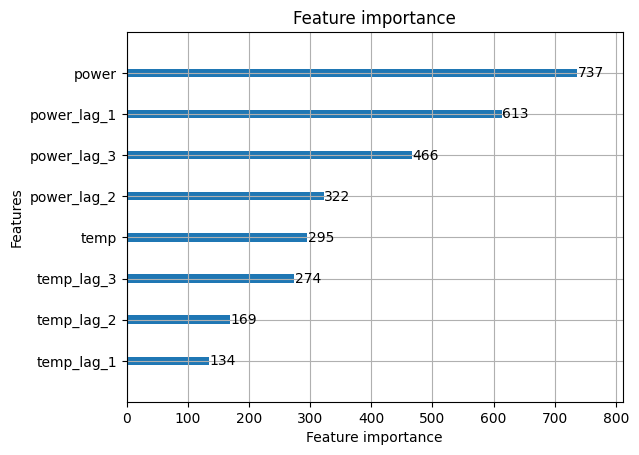

In [21]:
lgb.plot_importance(final_model)

In [ ]:
lgb.plot_tree(final_model, tree_index = 0, show_info=['split_gain'], precision=2, orientation='vertical')
# Save the plot as a PNG file with higher DPI
# plt.savefig('tree_plot.png', dpi=1200)

## Merging the predictions
In this section we create a new dataframe with time, power and its respective prediction.

In [61]:
# adding "predictions" column to our historical data frame after done training for futher plotting
historical_dataframe["predictions"] = final_model.predict(historical_dataframe.drop(columns=['target_power','time'],axis =1).astype('float32'))
# denormalizing the "predictions" values
historical_dataframe["predictions"] = (historical_dataframe["predictions"] * normalized_std) + normalized_mean
# merging the each predicion with its repective time to the main dataframe
prediction_dataframe = pd.merge(concatinated_df, historical_dataframe[['time', 'predictions']], on='time', how='left')
prediction_dataframe.rename(columns={'predictions': 'GBM_model'}, inplace=True)

## Plotting the prediction vs actuals

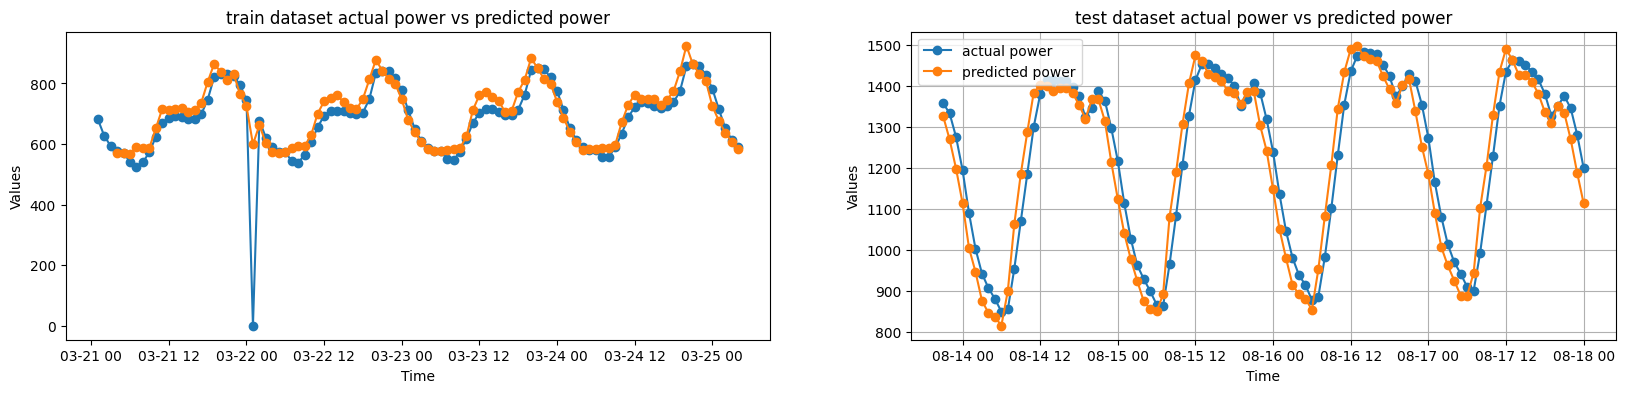

In [68]:
train_length = int(len(historical_dataframe)*0.7)
train_prediction_dataframe = prediction_dataframe.loc[:train_length, ["time", "power","GBM_model"]]
test_prediction_dataframe = prediction_dataframe.loc[train_length:, ["time", "power","GBM_model"]]
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
# Plotting power against Time
plt.plot(train_prediction_dataframe['time'][:100],
         train_prediction_dataframe['power'][:100],
         label='actual power', marker='o', linestyle='-')

# Plotting predictions against Time
plt.plot(train_prediction_dataframe['time'][:100],
         train_prediction_dataframe['GBM_model'][:100],
         label='predicted power', marker='o', linestyle='-')

plt.title('train dataset actual power vs predicted power')
plt.xlabel('Time')
plt.ylabel('Values')

plt.subplot(1, 2, 2)
# Plotting power against Time
plt.plot(test_prediction_dataframe['time'][:100],
         test_prediction_dataframe['power'][:100],
         label='actual power', marker='o', linestyle='-')

# Plotting predictions against Time
plt.plot(test_prediction_dataframe['time'][:100],
         test_prediction_dataframe['GBM_model'][:100],
         label='predicted power', marker='o', linestyle='-')

plt.title('test dataset actual power vs predicted power')
plt.xlabel('Time')
plt.ylabel('Values')

plt.legend()
plt.grid(True)
plt.show()

# Neural Network model
developing a simple MLP for prediction task using Pytorch framework

In [3]:
# Standard PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data preparation
Now to train our NN model, we need to prepare our dataset accordingly. Since we are going to predict a future value based on a window_size vaiable, first: we normalize the "power" column to have mean=0 and std =1, Then: we use the function "create_historical_dataset" to create a historical dataset based on the winodw_size varialbe.

In [4]:
from data_manipulation import std_normalizer ,create_historical_dataset

# Normalizing using the Standard Deviation Normalization method
normalized_concatinated_df , (normalized_mean , normalized_std) = std_normalizer(df= concatinated_df,col_name= "power")

# make a historical dataset for models to predict on.
window_size = 3
exclude_columns = ['time']  # Specify columns to exclude from lag feature creation
historical_dataframe = create_historical_dataset(normalized_concatinated_df, window_size, exclude_columns)


Normalization is done for column : power


### Splitting and converting data into torch.Tensor

In [5]:
# convert the data to a PyTorch tensor
X = torch.tensor(historical_dataframe.drop(columns=['target_power','time'],axis =1).astype('float32').values, dtype=torch.float32)
y = torch.tensor(historical_dataframe['target_power'].astype('float32').values, dtype=torch.float32)
y = y.view(-1,1)
# splitting the data into three parts , train, eval and test
# Split the data into training and the rest (temp_data)
X_train, temp_data, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Split the temp_data into evaluation and test sets
X_eval, X_test, y_eval, y_test = train_test_split(temp_data, y_temp, test_size=0.5, random_state=42)

# Convert training data to PyTorch DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

## Constructing the model
Making a class with dynamic number of layes. The number of layers will be calculated futher in grid-search phase.

In [6]:
class NeuralNetwork(nn.Module):
  def __init__(self, input_size:int, num_hidden_units:int, num_layers:int):
    super().__init__()
    layers = []
    layers.append(nn.Linear(input_size, num_hidden_units))
    layers.append(nn.ReLU())
    for _ in range(num_layers - 1):
        layers.append(nn.Linear(num_hidden_units, num_hidden_units))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p=0.2))
    layers.append(nn.Linear(num_hidden_units, 1))
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

## Grid-search hyper-parameter tuning
For tuning the hyper-parameters of the NN model we use "Grid-search" technique

In [7]:
# Grid search hyperparameter tuning
param_grid = {
    'num_hidden_units': [16, 32],
    'num_layers': [2, 3,4],
    'learning_rate': [0.001, 0.01, 0.1]
}

best_params = None
best_loss = float('inf')

In [ ]:
from helper_functions import train_step, test_step, train

# for loop to search the parameter space for the best parameters
# Convert test data to PyTorch tensor
eval_data = (X_eval, y_eval)
test_data = (X_test, y_test)
counter = 1

for params in ParameterGrid(param_grid):
  print(f"{counter} set of params in total of {len(ParameterGrid(param_grid))}")
  learning_rate = params['learning_rate']
  del params['learning_rate']  # Remove learning_rate from params

  model = NeuralNetwork(input_size=X.shape[1], **params).to(device)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # train the model
  results = train(model=model,
                  train_dataloader = train_loader,
                  test_data = eval_data,
                  optimizer = optimizer,
                  criterion = criterion,
                  epochs = 10,
                  device = device)

  # now test the model on test data
  test_loss = test_step(model=model,
                        test_data = test_data,
                        criterion = criterion,
                        device = device)
  if test_loss < best_loss:
    best_loss = test_loss
    best_params = params
    best_learning_rate = learning_rate

  counter +=1

print("Best Hyperparameters:", best_params)
print("Best Test Loss:", best_loss)
print("Best Learning Rate:", best_learning_rate)

## Training the model using the grid-search hyper-parameter tuning method

In [9]:
# Train the best model on the entire dataset
best_model = NeuralNetwork(input_size=X.shape[1], **best_params).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)
criterion = nn.MSELoss()

results = train(model= best_model,
                train_dataloader = train_loader,
                test_data = test_data,
                optimizer = optimizer,
                criterion = criterion,
                epochs = 10,
                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2891 | test_loss: 0.0466 | 
Epoch: 2 | train_loss: 0.0745 | test_loss: 0.0441 | 
Epoch: 3 | train_loss: 0.0628 | test_loss: 0.0349 | 
Epoch: 4 | train_loss: 0.0569 | test_loss: 0.0363 | 
Epoch: 5 | train_loss: 0.0562 | test_loss: 0.0326 | 
Epoch: 6 | train_loss: 0.0541 | test_loss: 0.0297 | 
Epoch: 7 | train_loss: 0.0507 | test_loss: 0.0671 | 
Epoch: 8 | train_loss: 0.0506 | test_loss: 0.0335 | 
Epoch: 9 | train_loss: 0.0466 | test_loss: 0.0627 | 
Epoch: 10 | train_loss: 0.0495 | test_loss: 0.0336 | 


## Merging the predictions

In [12]:
historical_dataframe["predictions"] = (best_model(X.to(device)).detach().cpu().numpy())
# denormalizing the "predictions" values
historical_dataframe["predictions"] = (historical_dataframe["predictions"] * normalized_std) + normalized_mean
# merging the each predicion with its repective time to the main dataframe
prediction_dataframe = pd.merge(concatinated_df, historical_dataframe[['time', 'predictions']], on='time', how='left')
prediction_dataframe.rename(columns={'predictions': 'NN_model'}, inplace=True)

## Plotting the predictions vs the real actual values

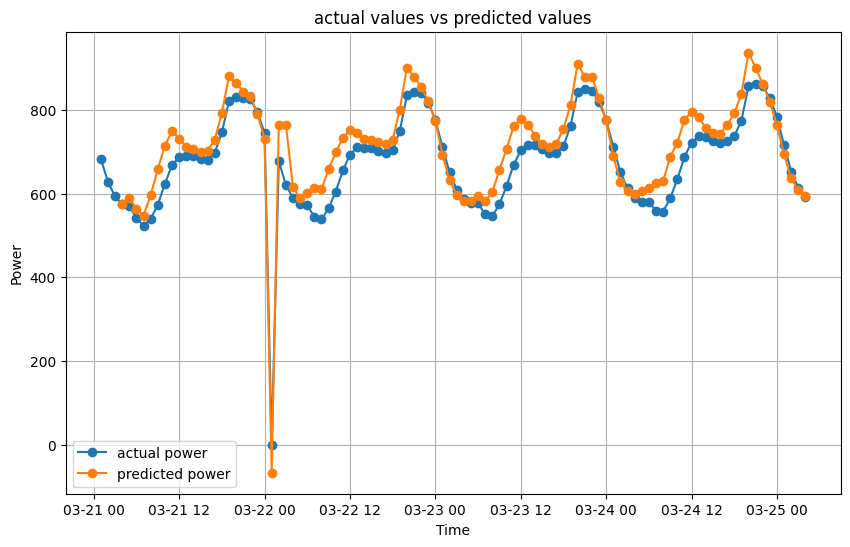

In [14]:
import matplotlib.pyplot as plt
# Plotting train dataset
plt.figure(figsize=(10, 6))

# Plotting power against Time
plt.plot(prediction_dataframe['time'][:100],
         prediction_dataframe['power'][:100],
         label='actual power', marker='o', linestyle='-')

# Plotting predictions against Time
plt.plot(prediction_dataframe['time'][:100],
         prediction_dataframe['NN_model'][:100],
         label='predicted power', marker='o', linestyle='-')

plt.title('actual values vs predicted values')
plt.xlabel('Time')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

# LSTM model

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [6]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data preparation

In [3]:
from data_manipulation import std_normalizer , create_sequences_with_target

# Normalizing using the Standard Deviation Normalization method
normalized_concatinated_df , (normalized_mean , normalized_std) = std_normalizer(df= concatinated_df,col_name= "power")

# removing the time column and converting the dataframe into a numpy array
# the index which we are going to predict is "power" which is 0
sequences, targets  = create_sequences_with_target(data = normalized_concatinated_df.drop(['time'],axis =1).to_numpy(),
                                                 sequence_length = 3,
                                                 target_feature_index = 0)

print("Original data shape:", concatinated_df.shape)
print("Sequences shape:", sequences.shape)
print("Targets shape:", targets.shape)


Normalization is done for column : power
Original data shape: (17519, 3)
Sequences shape: (17516, 3, 2)
Targets shape: (17516,)


## Convert the processed data to PyTorch tensors

In [11]:
# convert the data to a PyTorch tensor
X = torch.tensor(sequences.astype(np.float32), dtype=torch.float32)
y = torch.tensor(targets.astype(np.float32), dtype=torch.float32)
y = y.view(-1,1)
# splitting the data into three parts , train, eval and test

# Split the data into training and the rest (temp_data)
X_train, temp_data, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Split the temp_data into evaluation and test sets
X_eval, X_test, y_eval, y_test = train_test_split(temp_data, y_temp, test_size=0.5, random_state=42)

# Convert data to PyTorch DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

## Constructing the model

In [13]:
# Custom LSTM implementation
class LSTMRegressor(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out, (hidden, cell) = self.lstm(x)
    out = self.fc(hidden[-1, : , :])
    return out


In [14]:
# checking the shapes in each batch
for batch , (X,y) in enumerate(train_loader):
  print(f"input size for each batch: {X.shape}")
  print(f"target size for each batch: {y.shape}")
  break

input size for each batch: torch.Size([16, 3, 2])
target size for each batch: torch.Size([16, 1])


## Hyperparameter tuning using grid-search

In [15]:
param_grid = {
    'num_layers': [2, 3],
    'hidden_size': [32, 64],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.0, 0.2, 0.4]
}

In [ ]:
from helper_functions import train, train_step, test_step
# for loop to search the parameter space for the best parameters
# Convert test data to PyTorch tensor
eval_data = (X_eval, y_eval)
test_data = (X_test, y_test)
counter = 1
# for loop to search the parameter space for the best parameters
best_loss = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
  # Initialize model
  model = LSTMRegressor(input_size= X.shape[2] , # Adjust input size for the number of features
                        hidden_size=params['hidden_size'],
                        num_layers=params['num_layers'],
                        output_size=1,  # Output size for regression
                        dropout_rate=params['dropout_rate']).to(device)

  # loss function
  criterion = nn.MSELoss()
  # optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

  # train the model
  results = train(model=model,
                  train_dataloader = train_loader,
                  test_data = eval_data,
                  optimizer = optimizer,
                  criterion = criterion,
                  epochs = 1,
                  device = device)

  # now test the model on test data
  test_loss = test_step(model=model,
                        test_data = test_data,
                        criterion = criterion,
                        device = device)
  if test_loss < best_loss:
    best_loss = test_loss
    best_model = model
    best_params = params
    best_learning_rate = params['learning_rate']

  counter +=1

print("Best Hyperparameters:", best_params)
print("Best Test Loss:", best_loss)
print("Best Learning Rate:", best_learning_rate)

## Train the model on the entire dataset

In [18]:
# Train the best model on the entire dataset
optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)
criterion = nn.MSELoss()

results = train(model= best_model,
                train_dataloader = train_loader,
                test_data = test_data,
                optimizer = optimizer,
                criterion = criterion,
                epochs = 30,
                device = device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0237 | test_loss: 0.0302 | 
Epoch: 2 | train_loss: 0.0232 | test_loss: 0.0284 | 
Epoch: 3 | train_loss: 0.0226 | test_loss: 0.0265 | 
Epoch: 4 | train_loss: 0.0227 | test_loss: 0.0240 | 
Epoch: 5 | train_loss: 0.0222 | test_loss: 0.0230 | 
Epoch: 6 | train_loss: 0.0228 | test_loss: 0.0228 | 
Epoch: 7 | train_loss: 0.0233 | test_loss: 0.0338 | 
Epoch: 8 | train_loss: 0.0213 | test_loss: 0.0294 | 
Epoch: 9 | train_loss: 0.0207 | test_loss: 0.0253 | 
Epoch: 10 | train_loss: 0.0219 | test_loss: 0.0309 | 
Epoch: 11 | train_loss: 0.0211 | test_loss: 0.0247 | 
Epoch: 12 | train_loss: 0.0207 | test_loss: 0.0429 | 
Epoch: 13 | train_loss: 0.0200 | test_loss: 0.0262 | 
Epoch: 14 | train_loss: 0.0206 | test_loss: 0.0247 | 
Epoch: 15 | train_loss: 0.0203 | test_loss: 0.0230 | 
Epoch: 16 | train_loss: 0.0197 | test_loss: 0.0299 | 
Epoch: 17 | train_loss: 0.0231 | test_loss: 0.0301 | 
Epoch: 18 | train_loss: 0.0220 | test_loss: 0.0237 | 
Epoch: 19 | train_loss: 0.0188 | test

## Merging the predictions

In [55]:
X = torch.tensor(sequences.astype(np.float32), dtype=torch.float32)
historical_dataframe["predictions"] = (best_model(X.to(device)).detach().cpu().numpy())[1:]
# denormalizing the "predictions" values
historical_dataframe["predictions"] = (historical_dataframe["predictions"] * normalized_std) + normalized_mean
# merging the each predicion with its repective time to the main dataframe
prediction_dataframe = pd.merge(concatinated_df, historical_dataframe[['time', 'predictions']], on='time', how='left')
prediction_dataframe.rename(columns={'predictions': 'LSTM_model'}, inplace=True)

## Plotting the predictions vs the real actual values

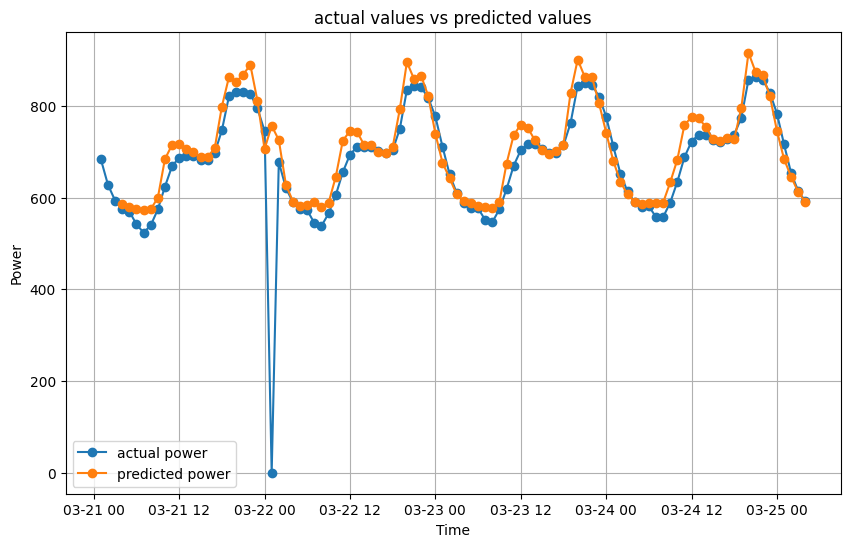

In [58]:
import matplotlib.pyplot as plt

# Plotting train dataset
plt.figure(figsize=(10, 6))

# Plotting power against Time
plt.plot(prediction_dataframe['time'][:100],
         prediction_dataframe['power'][:100],
         label='actual power', marker='o', linestyle='-')

# Plotting predictions against Time
plt.plot(prediction_dataframe['time'][:100],
         prediction_dataframe['LSTM_model'][:100],
         label='predicted power', marker='o', linestyle='-')

plt.title('actual values vs predicted values')
plt.xlabel('Time')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()